In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

## Lectures 3 - More about integration


Beyond solving differential equations, which we will continue to do, we are often interested in evaluating integrals numerically, particularly those that do not have useful analytic solutions. We're looking for an area (or higher-dimension equivalent) under a function, and there are two natural ways to do this:
  - chop into small intervals, approximate the heights in the intervals, and sum the chopped areas. There are many approaches and variations, but the main differences are in how to estimate accurately the average function value in the interval (height). Once can also optimize the interval chopping, putting more intervals where the function is changing more rapidly.
  - Monte Carlo (MC) techniques. Simplistic description: throw darts randomly at a plot, and count the fraction of the darts that land beneath the curve. For many-dimensional integrations of complex systems, this turns out to be quite effective. Example applications include simulations of the passage of particles through detectors, volumes of complex structures, and probabilty calculations in complicated systems (actually, detector simulations often encompass all of these).
  
Overview of the methods here, and we will return to more of the details of MC techniques later in the quarter.

### Basic numerical approach

Riemann: the limit of the sum over rectangular boxes whose width, $h$, approaches zero:

$$
  \int_{a}^{b} f(x)  dx = \lim_{h\rightarrow 0} \left[h
    \sum_{i=1}^{(b-a)/h} f(x_{i}) \right].$$


Numerically: a *finite* sum over $N$ boxes of height $f(x_i)$ and width
$w_i$:

$$\int_{a}^{b} f(x)  dx \simeq \sum_{i=1}^{N} f(x_{i}) w_{i},$$

which is similar, but both $h$ and $N$ are finite for purposes of computation.

<img src="figures/simple-int.png" width="50%">


Standard form for these algorithms:
* the function $f(x)$ is evaluated for each of the $N$ intervals, providing the information about the height of each box.
* these are summed with weights $w_i$, which usually take into account (or simply are, depending on the algorithm) the box widths.

Effectively, the different methods are encoded in the different $w_i$, as we will see, so we can describe a rule by its weight set $w_i=\{ , , ... , \}$.

Note: there is not really a "best" algorithm. Depends on $f(x)$ characteristics and what you need from the result. Some employ hypbrid approaches, switching algorithms as needed in an attempt to optimize the result.

### Trapezoid

The simple "box" method (using the function value at the start of each interval) has obvious limitations. 

Instead of assuming the function is constant over the interval, approxiate the function as a straight line over the interval, so the box is now a trapezoid, and use the function values at the start and end of the interval to define the line. In other words, use the simple average of the two function values as the box height estimator. This is not more expensive computationally, we we need the function value at the next point for the next box in the sum. Let's see how that works.

For $N$ points $x_i$ $(i = 1, N)$ evenly spaced (width $h$) 
throughout the integration region $[a, b]$, *including the
endpoints*, in the integration region, there are
$(N − 1)$ intervals of width $h$:

$$h= \frac{b-a}{N-1},\qquad x_{i} = a + (i-1) h, \qquad i=1, N,$$

Note: we start our counting at $i = 1$. 

$$\int_{x_{i}}^{x_{i}+h}f(x) dx \simeq \frac{h(f_{i}+f_{i+1})}{2} =
\frac{1}{2}hf_{i} + \frac{1}{2}hf_{i+1}.$$

<img src="figures/Trapezoid_Rule.png" width="50%">

In terms of our standard integration formula, the trapezoid rule has *individual interval* weights $w_i = \frac{h}{2}$, but when applying the rule to the entire $[a,b]$, we add the
contributions from each interval:

$$
\int_{a}^{b}f(x)  dx \simeq \frac{h}{2}f_{1} + hf_{2}
  +hf_{3} + \cdots + hf_{N-1} + \frac{h}{2}f_{N} .$$

Notes:
  - internal points are counted twice (as the end of one interval and as the beginning of the next), so they have *total weights* of $h/2 + h/2 = h$, 
  - endpoints are counted just once, so they have *total weights* of $h/2$. 
  
For the trapezoid algorithm, the weight set is:
$$w_i= \{ \frac{h}{2}, h, h, ..., h, h, \frac{h}{2}\}$$

In code, integrating a $f(y)$ over the region from A to B using N points or (N-1) intervals (see listing *TrapMethods.py* in the textbook for a slightly different coding approach):

In [16]:

A = 0.0
B = 3.0
N = 1001
# N points => (N-1) intervals

def f(y):           # Integrand
    return y*y

h = (B - A)/(N - 1)
w = np.zeros(N).astype('float')
w=h*(w+1.)
w[0]=w[N-1]=h/2.
#print(w[0:N])

sumt = 0.0
wsum=0.

for i in range(1, N + 1):   # meh...the book defines the first point having index 1, not 0.
    y = A + (i - 1)*h
    sumt  += w[i-1] * f(y)
    wsum += w[i-1]


#    print(i, w[i-1],y)
    
print('Trapezoid result = ', sumt)
print('\n Weight sum = ', wsum)

Trapezoid result =  9.000004499999998

 Weight sum =  3.0000000000000027


which isn't bad: the answer should be 9.0 for A=0, B=3, $f(y)=y^2$. Note that the sum of the weights should be the total interval of integration (see below).



### Simpson’s Rule

A better approach is to approximate the function with a second-order polynomial (instead of a line) over the interval, and this is done for each interval:

$$\begin{align}
f(x) \simeq \alpha x^{2} + \beta x + \gamma ,
   \end{align}$$
   
<img src="figures/Simpson.png" width="50%">


Obtain weights by calculating the area under the parabola directly:
  
  - for equally spaced intervals, the area under the parabola for each interval is

$$
\int_{x_i}^{x_i+h}(\alpha x^{2} + \beta x +\gamma)  dx = \left.
( \frac{\alpha x^3 } { 3} +   \frac{\beta x^2} { 2}
    + \gamma x) \right|_{x_i}^{x_i+h}.$$

To get the parameter values for $\alpha$, $\beta$, and $\gamma$, notice that for 
an interval from −1 to +1:

$$
\int_{-1}^{1}(\alpha x^{2} + \beta x +\gamma)  dx =
\frac{2\alpha}{3} + 2\gamma.$$

and 

$$
\begin{align}
 f(-1) & = \alpha -\beta+\gamma, \quad  f(0) = \gamma, \quad f(1) = \alpha + \beta +
  \gamma,\\
  \Rightarrow & \alpha = \displaystyle \frac{f(1)+f(-1)} { 2} -f(0), \quad
   \beta =       \frac{f(1)-f(-1)} { 2},  \quad \gamma= f(0).
   \end{align}$$

  * => can express the integral as the weighted sum over the values of the function at three points:

$$
\int_{-1}^{1}(\alpha x^{2} + \beta x +\gamma)  dx =
\frac{f(-1)}{3} + \frac{4f(0)}{3} + \frac{f(1)}{3} .$$

The individual weights for one step are therefore $(h/3, 4h/3, h/3)$.

Three values of the function are needed for each step, so it makes sense to do the sums for *pairs* of intervals:

$$\begin{align}
\int_{x_{i}-h}^{x_{i}+h}f(x)  dx & =  \int_{x_{i}}^{x_{i}+h}f(x)
dx + \int_{x_{i}-h}^{x_{i}}f(x) dx\\
  & \simeq   \frac{h}{3}f_{i-1}
    + \frac{4h}{3}f_{i} + \frac{h}{3}f_{i+1} .\tag*{5.40}
   \end{align}$$

and then hop ahead to the next pair. Thus,

  * Simpson’s rule requires the sum to be over *pairs* of intervals, which in turn requires that the *total number of intervals be even (and therefore that the number of points $N$ be odd*). 
  * In order to apply Simpson’s rule to the entire , we add up the contributions from each pair of subintervals, again effectively counting all but the first and last endpoints twice:

$$\int_{a}^{b}\!\!f(x)dx \simeq \frac{h}{3}f_{1} +
\frac{4h}{3}f_{2}+ \frac{2h}{3}f_{3} + \frac{4h}{3}f_{4} + \cdots
+\frac{4h}{3}f_{N-1} + \frac{h}{3}f_{N}.
\tag*{5.41}$$

Therefore, the resulting for Simpson's rule are:

$$\tag*{5.42}
  w_{i} = \left\{\frac{h}{3},  \frac{4h}{3},
\frac{2h}{3},  \frac{4h}{3},   \ldots,
    \frac{4h}{3},   \frac{h}{3} \right\} \qquad   \mbox{(Simpson's rule)}.$$

The sum of these weights provides a useful check:

$$
\sum_{i=1}^{N} w_{i} = (N-1) h.$$

so this should be the size of the interval of integration.

*Repeating:* the number of points $N$ must be odd for Simpson’s rule. Let's try our code example, substituting Simpson for trapezoid:

In [17]:
A = 0.0
B = 3.0
N = 1001
# N points => (N-1) intervals

def f(y):           # Integrand
    return y*y

h = (B - A)/(N - 1)
# here's a more efficient and elegant way to fill the weights
w=np.empty(N) ; w.fill(2.*h/3.)  # I prefer never to use .empty unless I also immediately initialize to something.
w[1::2] = 2. * w[1::2] # double every other one to be 4/3 h, starting with element 1 (the second in the set)
w[0] = h/3. # overwrite the zeroth and last elements (the ends of the set)
w[-1] = h/3.

"""" This was the first way we implemented it
w = np.zeros(N).astype('float')
w=h/3.*(w+1.) # see the vector operation?
for i in range(1,N-1):
    if (int(i/2)==float(i)/2.):
        w[i]=2.*w[i]
    else:
        w[i]=4.*w[i]"""

print(w[0:N])

sums = 0.0
wsum=0.
for i in range(1, N + 1):   # meh...the book defines the first point having index 1, not 0.
    y = A + (i - 1)*h
    sums  += w[i-1] * f(y)
    wsum += w[i-1]
#    print(i, w[i-1],y, wsum)
    
print('Simpson result = ', sums)
print('\n Weight sum = ', wsum)
print ('\n Simpson error = ','%.5e'% (sums/9.-1.))
print ('\n Trapezoid error = ',sumt/9.-1.)

[0.001 0.004 0.002 ... 0.002 0.004 0.001]
Simpson result =  9.000000000000009

 Weight sum =  2.9999999999999654

 Simpson error =  8.88178e-16

 Trapezoid error =  4.999999996257998e-07


**Whoa! That's not better than Trapezoid! What did we do wrong, and how do we fix it?**

$$ $$
$$ $$

...after the fix:
Ah...**much better!** by about 9 orders of magnitude relative to trapezoid (for this caase). Probably a good idea to test that $N$ is odd, so that the number of intervals is even. See cell below.

#### Romberg improvements

Try canceling leading errors by combining two different calculations:

Start with the trapezoid rule, using $N=2^m$ intervals with width $h$.  Call this result $A(h)$ (your book's notation).

$$A(h) = \int_a^b f(x) dx + \alpha h^2 + \beta h^4 + \dots$$

Now let's rerun the trapezoid rule, using $N=2^{m+1}$ intervals (*i.e.*, doubled the number) with width $h/2$.
This result has 1/4 the error of the lower-resolution result.

$$A(h/2) = \int_a^b f(x) dx + \alpha \frac{h^2}{4} + \beta \frac{h^4}{16} + \dots$$

Now, simply cancel the leading error ($\mathcal{O}(h^2)$) and get a better integral approximation by subtracting the two results, suitably weighted:

$$\frac{4}{3}A(h/2) - \frac{1}{3}A(h) = \int_a^b f(x) dx - \beta \frac{h^4}{4} + \dots$$

Voilá, one order better. In fact, when you put the pieces together, this result is arithmetically equivalent to Simpson's rule.

You can keep iterating to improve the error. Since it is complicated to keep calculating the coefficients of the leading error terms, it is common to stop the iterations when the integral is no longer changing significantly relative to its value.

There are other variations that lead to different weighting schemes. See Table 5.1 in your textbook if you are interested.


#### Refinements and other approaches
As with the ODE solvers, there are many refinements, especially adaptive algorithms.

-----------


In [21]:
# one of many ways to test that a number is even:
m=3
if m%2 == 0:
    print("This value is even:",m)
else:
    print ("This value is odd:",m)
    
# modulo arithmetic also works with floats 
#the=(5/2)*np.pi
#print(the%(2*np.pi))

This value is odd: 3


### Beware singularities and challenging regions

If integrand contains a singularity or discontinuity (but integral is finite, of course), must first remove it before applying numerical methods. (See book chapter 26.4 for general discussion.)

   - avoidance: break up integral around the singularity or discontinuity. Example:
$$
\int_{-1}^{1} f(|x|)  dx =  \int_{-1}^{0}f(-x)  dx +
\int_{0}^{1}f(x)  dx
$$


   - change of variable


$$
\begin{align}
\int_{0}^{1}\frac{f(x)  dx}{\sqrt{1-x^{2}}} &=
 \int_{0}^{1}\frac{f(1-y^{2})  dx}{\sqrt{1-(1-y^2)^{2}}}, \quad (y^{2}  =  1-x) \\
 &= \int_{1}^{0}\frac{f(1-y^{2})  (-2y dy)}{y\sqrt{2-y^2}}\\
 &= 2\int_{0}^{1}\frac{f(1-y^{2})  dy}{\sqrt{2-y^{2}}},
\end{align}
$$

If integrand has a very rapid variation in some region, can
change variables to expand that region to ensure that no signficant features are missed. Conversely, if integrand has very slow variation in some region, can speed up the integration by changing to a variable that
compresses that region and places few points there, or divide the
interval and use different step sizes (or use an adaptive method). 



### Improper Integrals

$$I  = \int_0^\infty f(x) dx$$

Of course, $\infty$ is a formal upper limit. In some cases, could simply put a large cutoff, $b$, that is *effectively* $\infty$ numerically (contributions beyond the cutoff are negligible).

Or, going further, split into a finite region and an infinite region:

$$\int_0^\infty f(x) dx = \int_0^a f(x) dx + \int_a^\infty f(x) dx$$

The finite region can be evaluated numerically, and the rest can be dealt with separately: for example, a common substitution of variables for the infinite region is $x\rightarrow 1/y$ so that the integral becomes

$$\int_a^\infty f(x)\ dx = \int_0^{1/a} \frac{f(y^{-1})}{y^2}\ dy$$

Notice that this would be unworkable if the region contained $x=0$, but that's already handled in the finite-region integral. There is the potentially problematic behavior near $y=0$, see discussion above. 

$$ $$ 

**Example**
$$I = \int_0^\infty \frac{dx}{1+x^2}$$
is challenging numerically with arbitrarily large cutoff $b$. Splitting the interval into two pieces: $[0,1]$ and $[1,\infty]$, and for the latter interval, substitute $x\rightarrow 1/y$ and try $a=1$.

$$
\begin{align}
I &= \int_0^1 \frac{1}{1+x^2} dx + \int_0^{1/a} \frac{1}{y^2 (1+1/y^2)} dy \\
&= \int_0^1 \frac{1}{1+x^2} dx + \int_0^{1} \frac{1}{(y^2+1)} dy \\
&= \int_0^1 \frac{1}{1+x^2} dx + \int_0^{1} \frac{1}{1+y^2} dy \\
\end{align}
$$



In [4]:
# Let's try this using our Trapezoid integrator from earlier:

A = 0.0
B = 1.0
N = 100
# N points => (N-1) intervals

def f(x):           # Integrand
    return 1./(1+pow(x,2))



h = (B - A)/(N - 1)
w = np.zeros(N).astype('float')
w=h*(w+1.)
w[0]=w[N-1]=h/2.
sumt = 0.0
wsum=0.

for i in range(1, N + 1):   # meh...the book defines the first point having index 1, not 0.
    y = A + (i - 1)*h
    sumt  += w[i-1] * f(y)
    wsum += w[i-1]

print('Trapezoid result = ', 2.*sumt) # 2* becuase we have the x and y integrals, which are functionally identical.
print('\n Weight sum = ', wsum)

Trapezoid result =  1.5707878242611426

 Weight sum =  0.9999999999999981


Analytically, $$I = \int_0^\infty \frac{dx}{1+x^2} = \frac{\pi}{2}$$

Not bad. It gets better with more subdivisions. Try it.

In [5]:
print ('Trapezoid result suggests pi = ','%.7e' % (4.*sumt))

Trapezoid result suggests pi =  3.1415756e+00


## Monte Carlo Methods
Summing boxes works well for many types of functions, but there are some practical limitations, particularly for multi-dimensional integrals. 

We can instead use random numbers to estimate the area (or N-dimensional volume). 
  - This opens a new issue for us: random numbers on a computer. We'll come back to this soon, but let's not digress too much right now.
  - There are (pseudo-) [random number generation algorithms](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.rand.html#numpy.random.rand) that work well for many applications. 


The simple random number generator returns numbers evenly distributed between 0 and 1. Let's populate a square of side length 2, centered at $x=y=0$, with random numbers. 
  - Try it with the same Ntot a few times. 
  - Then change Ntot.
  - Then use the box of random numbers to calculate $\pi$. This will be your first MC method. Then explore how the precision improves with the number of randoms in the box.
    - why is this called a MC method? [Here's](http://www.casinomontecarlo.com) the reason.

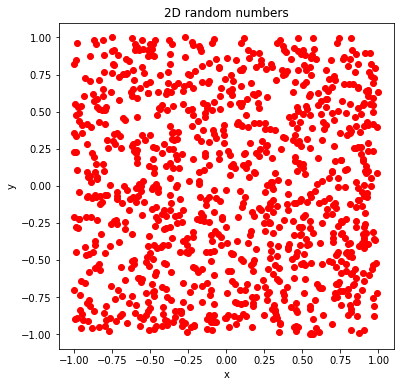

In [53]:
Ntot=1000
z=2.*(np.random.rand(Ntot,2)-0.5)
plt.rcParams["figure.figsize"] = (6.,6.)
plt.plot(z[:,0],z[:,1],"o",c='r')
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D random numbers")
plt.show()


### Introduction to Monte Carlo Integration

Finding an accurate, effective average value of the integrand over an interval was the main challenge in the numerical integration techniques above. 

$$I = \int_{a}^{b} f(x)\ dx = (b-a)\langle f \rangle$$

Rather than constructing estimators using function expansions and analytic approximations, and/or clever weights, we can just ask random numbers, $x_i$, to do the job for us: evaluate $f(x_i)$ with $N$ of the $x_i$ and calculate the mean value:

$$\langle f \rangle \simeq \frac{1}{N}\sum_{i=1}^{N} f(x_{i})$$

   - Notice, no chopping! This works fine over the whole integration range.
   - We just must use enough $x_i$ so that the statistical error is acceptable. Recall the central limit theorem, see below and Problem set 3.
     - of course, this works only if the $x_i$ are randomly and uniformly distributed 

The general Monte Carlo integration rule is thus:

$$\int_{a}^{b} f(x)\ dx \simeq (b-a) \frac{1}{N}\sum_{i=1}^{N} f(x_{i})$$

Without any optimization, we can approximate the true integral with $N$ sufficiently large (or, equivalently, if we make many "measurements" of $I$).

The uncertainty on this result is estimated by the variance:

$$\begin{align}
\sigma_I^2 &\simeq \frac{1}{N} \sigma_f^2 \\
&= \frac{1}{N} \left[ \frac{1}{N} \sum_{i=1}^N f_i^2 - \left( \frac{1}{N} \sum_{i=1}^N f_i \right)^2 \right]
\end{align}$$

so the uncertainty in the estimate of the integral decreases as $N^{-1/2}$, which matches our experience with the "measurement" of $\pi$ using the 2D space of randoms, above.

Compared with the other numerical methods (e.g., trapezoid), which have uncertainties $\sim N^{-2}$, this might not seem valuable, but for multidimensional integrals a MC method has advantages.

** Example **

Let's try it on the same integral we had above:
$$\int_0^1 \frac{dx}{1+x^2} = \frac{\pi}{4} = 0.785$$


For N= 1000 I= 0.78182 +/- 0.00520


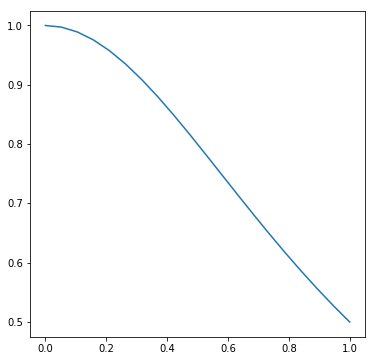

In [7]:
def f(x):
    return 1./(1+pow(x,2))

N = 1000
sum = 0.
sum2 = 0.
for i in range(N):
    x = np.random.random()
    sum += f(x)
    sum2 += pow(f(x),2)
result = sum/N
sigma = np.sqrt((sum2/N - pow(sum/N,2))/N)
print("For N=", N, "I=",'%.5f'% result, "+/-" ,'%.5f'% sigma)

# btw, let's look at the function we're integrating
x = np.linspace(0,1,20)
y = f(x)
plt.plot(x,y)
plt.show()

##### Importance Sampling

In the error estimate, the *variance of the integrand* (see above) is just as important as the factor $1/N$

=> try to reduce the variation in the integrand over the interval (flatten it) to improve the uncertainty in the integral result without increasing $N$.

May seem silly, but divide and multiply the integrand by a carefully chosen normalized weight function $w(x)$:

$$\begin{align}
I &= \int_a^b f(x) dx \\
&= \int_a^b \frac{f(x)}{w(x)} \ w(x) \ dx \\
\end{align}
$$

and change variable from $x$ to $y$ so that

$$y = \int_a^x w(t) \ dt$$

then we are using the *cumulative probability distribution* of $w(x)$.  (Normalized means $\int_a^b w(x) dx = 1$.)

The integral $I$, under the change of variables, becomes

$$
I = \int_{y_a}^{y_b} \frac{f(x(y))}{w(x(y))} \ dy
= \frac{1}{N} \sum_{i=1}^N \frac{f}{w}
$$

If we choose a function $w(x)$ that has similar behavior to $f(x)$, then the integrand will be smooth , with a small variance.

In other words:

  - instead of uniformly sampling $x$ to integrate $f(x)$, we uniformly sample $y$ and integrate $f(x)/g(x)$.
  - a uniform distribution of points in $y$ yields a distribution of points in $x$ distributed as $dy/dx = w(x)$.
    
Thus, the integration points are concentrated in the regions of $x$ where $w(x)$ (and hopefully $f(x)$, by design) are large, so we are sampling the points that are most important to the sum approximating the integral.

For that reason, this kind of sampling is called *importance sampling*.

The challenge of importance sampling is finding a good $w(x)$ and writing the transform $x\rightarrow y$.

Back again to our example
$$\int_0^1 \frac{dx}{1+x^2}$$

The integrand is monotonically decreasing , so we will look for a $w(x)$ that is roughly of the same order and decreases with $x$.

A good choice is 
$$w(x) = \frac{1}{3} (4-2x)$$
This has the benefit of already being normalized over the interval [0,1], it has near-unity values of 3/4 at both endpoints, and it is nearly flat everywhere in the interval.

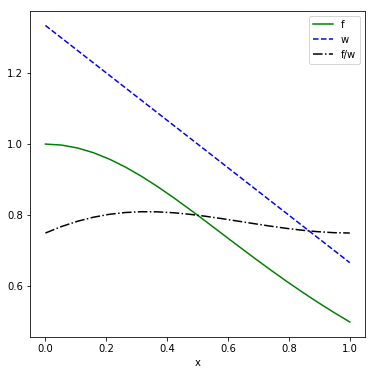

In [8]:
x = np.linspace(0,1,20)
f = 1./(1+pow(x,2))
w = 1./3. * (4-2*x)
fplot, = plt.plot(x, f, "g")
wplot, = plt.plot(x, w, "b--")
ratioplot, = plt.plot(x, f/w, "k-.")
plt.xlabel("x")
plt.legend([fplot, wplot, ratioplot], ['f', 'w', 'f/w'])
plt.show()

According to our recipe
$$\begin{align}
y(x) &= \int_0^x w(t)\ dt \\
&= \int_0^x \frac{1}{3} (4-2t) \ dt \\
&= \frac{1}{3} x (4-x)
\end{align}$$

The x-values for the function evaluation are now $x(y)$:

$$x = 2 - (4-3y)^{1/2}$$

and the limits of integration are $y_a = y_0 = 0$ and $y_b = y_1 = 1$.


In [37]:
# Monte Carlo integration with importance sampling

def f(x):
    return 1./(1+pow(x,2))

def w(x):
    return (4. - 2.*x)/3.

def xx(y): 
    return 2. - np.sqrt(4 - 3*y)

N = 1000
sum = 0.
sum2 = 0.
x = np.zeros(N).astype('float')
for i in range(N):
    y = np.random.random()
    x[i] = xx(y)
    integrand = f(x[i])/w(x[i])
    sum += integrand
    sum2 += pow(integrand,2)
result = sum/N
sigma = np.sqrt((sum2/N - pow(sum/N,2))/N)
print("For N=", N, ": ", result, "+/-", sigma)

For N= 1000 :  0.7854710953321565 +/- 0.000621000971902816


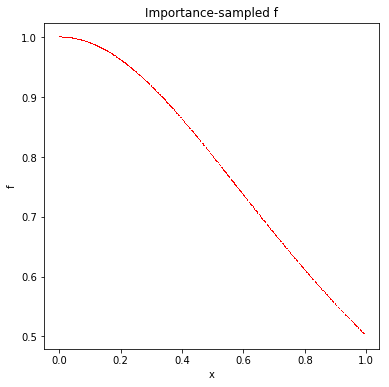

The bin contents: [249. 231. 193. 183. 144.]


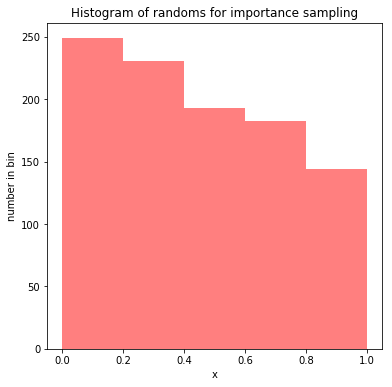

In [51]:
# now let's plot f and the xx (importance-sample) distribution
xzeros=0.*x
plt.rcParams["figure.figsize"] = (6.,6.)
#plt.plot(x,xzeros,".",c='r')
plt.plot(x,f(x),",",c='r')
plt.xlabel("x")
plt.ylabel("f")
plt.title("Importance-sampled f")
plt.show()
bins=np.arange(0,1.2,.2)
# the histogram of the data
n, binsa, patches = plt.hist(x, bins, facecolor='red', alpha=0.5, align='mid')
plt.xlabel('x')
print ("The bin contents:",n)
plt.ylabel('number in bin')
plt.title(r'Histogram of randoms for importance sampling')
plt.show()



Thus, the uncertainty has been reduced by almost a factor of 10 for $N=1000$.

There is a **simpler way** to generate random points with a specified probability distribution $w(x)$: the *von Neumann method (acceptance/rejection method)* can generate a sequence that follows $w(x)$.

This is clearly more generally valuable: we'd like to be able to generate random numbers according to any distribution we want (not just flat between 0 and 1). While there are numpy and other functions to do this, it's valuable for us to be able to do it. 

Some example applications?

### von Neumann method (acceptance/rejection)

1. Consider a graph of $w(x)$ *vs.* $x$ Construct a rectangular area (box) that encompasses $a$ to $b$ in $x$ and $w_\text{min}$ to $w_\text{max}$. The top and bottom edges of the box can be any values, as long as all possible values of $w(x)$ are included, but it's wasteful to make the box too big, as we'll see.

<img src="Figures/Figure_5.8.png" width="40%">

2. Now generate random numbers, $x_i$, that uniformly span the interval $a$ to $b$. Also generate a second set of random numbers, $W_i$, that uniformly span the interval from $w_\text{min}$ to $w_\text{max}. 

3. Reject all $(x_i, W_i)$ points that do not fall into the region below the curve:
$$
\mbox{If} \ W_{i} \lt w(x_{i}),  \ \mbox{accept}, \quad
  \mbox{If} \ W_{i} \gt w(x_{i}),\  \mbox{reject}$$

The $x_i$ values that are accepted will have the weighting
probability $w(x)$. The largest acceptance occurs where $w(x)$ is
large, as shown for midrange $x$ in the figure, so there are some inefficiencies (you throw away many generated $x_i$) where $w(x)$ is small. Thus,
  - It's a good idea to specify the number of resulting random numbers you want, rather than the number of trials.
  - It's a good idea to plot the function and generated random numbers to verify.
  
Let's try it: **generate $x_i$ between 0 and 5 that follow a probability distribution** $w(x)\sim x^2$. 

First, let's realize that $w(x)=Ax^2$ is a probability density: $\int_a^b w(x)\ dx=1$, so we need to find the normalization, *i.e.*, $\int_a^b Ax^2\ dx=1$,  so in our case $A=\frac{3}{5^3}$. 

The bin contents: [  73.  528. 1526. 2870. 5003.]


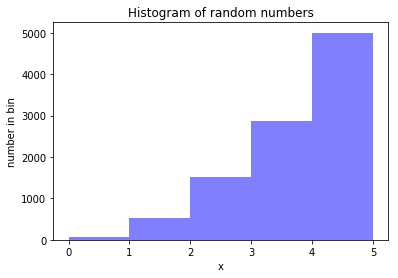

In [4]:

def w(x):
    return (3./pow(5.,3))*x*x

N = 10000
ranx2 = np.zeros(N).astype('float')
i=0
while (i<N):
    r1,r2 = 5.*np.random.random(2)
    if (r2<w(r1)):
        ranx2[i]=r1
        i+=1
bins=[0,1,2,3,4,5]
# the histogram of the data
n, binsa, patches = plt.hist(ranx2, bins, facecolor='blue', alpha=0.5, align='mid')
plt.xlabel('x')
print ("The bin contents:",n)
plt.ylabel('number in bin')
plt.title(r'Histogram of random numbers')
 
plt.show()


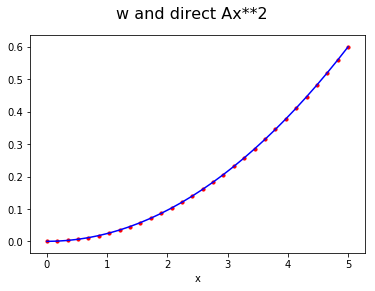

probabilties by bin from histo:  [0.0073 0.0528 0.1526 0.287  0.5003]
calculated probablities by bin:  [0.008 0.056 0.152 0.296 0.488]
check sums of probs each type:  1.0 1.0


In [5]:
# let's check that we got what we expected:
#    plot w(x), and integrate it over the interval to make sure it is normalized
#    calculate probability for each bin (integrate w(x) over each bin)
#    compare with the fraction of generated numbers actually in each bin
x = np.linspace(0,5,30)
plt.plot(x, w(x), "b")
plt.scatter(x, 3.*x*x/pow(5,3), 10, 'r')
plt.xlabel("x")
plt.suptitle('w and direct Ax**2', fontsize=16)
plt.show()
probsh=n/N
print ("probabilties by bin from histo: ",probsh)
probsc=probsh*0.
psum=0.
hsum=0.
for i in range (0,len(n)):
    probsc[i]=1/pow(5.,3)*(pow(bins[i+1],3)-pow(bins[i],3))
    psum+=probsc[i]
    hsum+=probsh[i]
print ("calculated probablities by bin: ", probsc)
print("check sums of probs each type: ",psum, hsum)

In [8]:
# let's integrate w over the interval to ensure we got the correct normalization. We'll reuse our Simpson rule code.
A = 0.0
B = 5.0
N = 12001
# N points => (N-1) intervals

h = (B - A)/(N - 1)
wts=np.empty(N) ; wts.fill(2.*h/3.)  # I prefer never to use .empty unless I also immediately initialize to something.
wts[1::2] = 2. * wts[1::2] # double every other one to be 4/3 h, starting with element 1 (the second in the set)
wts[0] = h/3. # overwrite the zeroth and last elements (the ends of the set)
wts[-1] = h/3.
sums = 0.0
wsum=0.
for i in range(1, N + 1):   # meh...the book defines the first point having index 1, not 0.
    y = A + (i - 1)*h
    sums  += wts[i-1] * w(y)
    wsum += wts[i-1]
#    print(i, w[i-1],y, wsum)
    
print('Simpson result = ', sums)
print('\n Weight sum = ', wsum)

Simpson result =  1.0000000000000033

 Weight sum =  5.000000000000624


**Looks good!**

----------- 

------------

Prompted by the above discussion, we can figure out a more efficient way to do this (and an interesting way to think about this problem), particularly for weighting functions that are integrable analytically: 
  - the random number generator gives us numbers between 0 and 1, and
  - $\int_a^b w(x) dx = 1$, so $\int_a^{x_i} w(x) dx$ is the probabilty, $p$, -- *also between 0 and 1*. 
  
So, we can performan in inversion. Generate a random number, $r_i$, uniformly between 0 and 1, then

$$ \int_a^{x_i} w(x) dx = r_i $$

If we can solve for $x_i$ (an inversion), then the $x_i$ will have the desired distribution **by definition**! This is particularly efficient, because there are no trials.

For our case of $w(x)=Ax^2$, we can see that $$x_i= \left (\frac{3r_i}{A}\right )^\frac{1}{3}$$

Let's try it: 




[  80323.  562180. 1521334. 2956198. 4879965.]


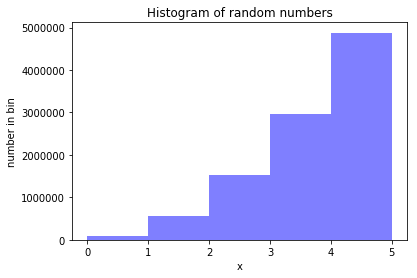

In [13]:
N = 10000000
ranx2 = np.zeros(N).astype('float')
A=3./5**3
r1 = np.random.random(N)
ranx2=(3.*r1/A)**(1./3.)
bins=[0,1,2,3,4,5]
# the histogram of the data
n, binsa, patches = plt.hist(ranx2, bins, facecolor='blue', alpha=0.5, align='mid')
plt.xlabel('x')
print (n)
plt.ylabel('number in bin')
plt.title(r'Histogram of random numbers')
 
plt.show()

In [14]:
# let's check that we got what we expected:
probsh=n/N
print ("probabilties by bin from histo: ",probsh)
probsc=probsh*0.
psum=0.
hsum=0.
for i in range (0,len(n)):
    probsc[i]=1/pow(5.,3)*(pow(bins[i+1],3)-pow(bins[i],3))
    psum+=probsc[i]
    hsum+=probsh[i]
print ("calculated probablities by bin: ", probsc)
print("check sums of probs each type: ",psum, hsum)

probabilties by bin from histo:  [0.0080323 0.056218  0.1521334 0.2956198 0.4879965]
calculated probablities by bin:  [0.008 0.056 0.152 0.296 0.488]
check sums of probs each type:  1.0 1.0


Very nice. It's not practical to generate 10 million of these with the rejection method (it takes a while, anyway), but it's very quick with this method. Also, this approach allows us to vectorize the operations, another speed bonus.

To recap: if you can perform the inversion, this is a very straightforward technique to generate random numbers according to the probability density of your choice.



#### Oh, and one more thing...
In class, someone asked if the inversion method can produce distributions for probability densities that are not monotonic. Yes! Let's make a distribution of randoms according to $\sin(x)$ for $x$ in the range $(0,\pi)$.

$$ A\int_0^{\pi} \sin(x) dx = 2A = 1 $$

so $A=\frac{1}{2}$, and

$$ \frac{1}{2}\int_0^{x} \sin(x') dx' = \frac{1}{2}(1-\cos(x)) = r $$

so

$$ x=\cos^{-1}(1-2r) $$

Let's see:



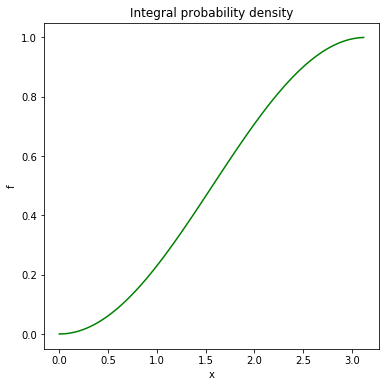

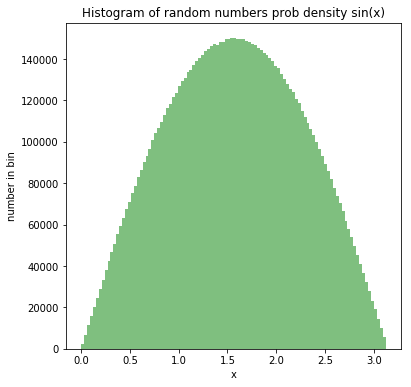

In [62]:
# first, let's have a look at the integral of the probability density
#plt.rcParams["figure.figsize"] = (6.,6.)
x=np.arange(0.,np.pi,.03)
wint=0.5*(1.-np.cos(x))
plt.plot(x,wint,c='g')
plt.xlabel("x")
plt.ylabel("f")
plt.title("Integral probability density")
plt.show()
N = 10000000
ranx2 = np.zeros(N).astype('float')
r1 = np.random.random(N)
ranx2=np.arccos(1.-2.*r1)
bins=np.arange(0.,np.pi,.03)
#print(bins)
# the histogram of the data
n, binsa, patches = plt.hist(ranx2, bins, facecolor='green', alpha=0.5, align='mid')
plt.xlabel('x')
#print (n)
plt.ylabel('number in bin')
plt.title(r'Histogram of random numbers prob density sin(x)')
plt.show()


------------
Let's have a look at problem set 3.